In [1]:
import os

In [2]:
import cv2
##TODO: 1.cluster predicted images' pixel values to certain pre-defined values
# read one image as an example
gt_image = cv2.imread(os.path.join("/home/sicong/imagen-sicong/dataset/imgs/","6282.png"))
pred_image = cv2.imread(os.path.join("/home/sicong/CogView/samples_text2image/exp_140k_itr/718/","3.jpg"))



In [3]:
pred_image[0,1]

array([38, 38, 38], dtype=uint8)

In [5]:
from tqdm import tqdm

In [6]:
last_5k_type = ['255,255,255', '0,0,0', '0,0,255', '170,232,238', '128,128,240', '230,216,173', '0,215,255', '0,165,255', '35,142,107', '221,160,221', '0,255,255', '214,112,218']
last_dict = dict.fromkeys(last_5k_type)
for key in last_dict.keys():
    last_dict[key] = [int(val) for val in key.split(',')]

In [7]:
from scipy.spatial import distance
import numpy as np
new_image = np.zeros((256,256,3))
keys = list(last_dict.keys())
for i in range(256):
    for j in range(256):
        pred_value = list(pred_image[i,j])
        distances = [distance.euclidean(pred_value, last_dict[key]) for key in keys]
        key_idx = distances.index(min(distances))
        new_image[i,j] = np.array(last_dict[keys[key_idx]],dtype=np.uint8)

In [8]:
cv2.imwrite('new_img.png', new_image)

True

In [9]:
##TODO: 2.generate room masks according to the refined images
def generate_mask(new_image, last_dict):
    dict_pred_mask = dict.fromkeys(last_dict.keys())
    for key in dict_pred_mask.keys():
        dict_pred_mask[key] = np.zeros((256,256))

    for key in dict_pred_mask.keys():
        for i in range(256):
            for j in range(256):
                if new_image[i,j,0] == last_dict[key][0] and new_image[i,j,1] == last_dict[key][1] and new_image[i,j,2] == last_dict[key][2]:
                    dict_pred_mask[key][i,j] = 1
    return dict_pred_mask

In [10]:
dict_pred_mask = generate_mask(new_image, last_dict)

In [11]:
dict_gt_mask = generate_mask(gt_image, last_dict)

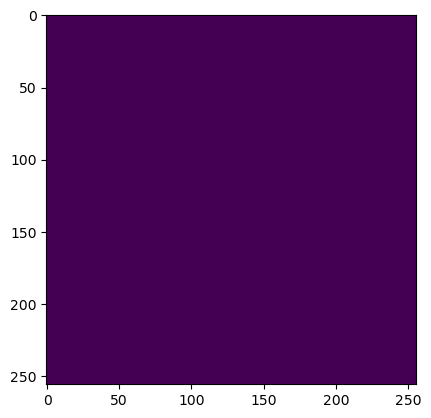

In [12]:
import matplotlib.pyplot as plt
plt.imshow(dict_gt_mask['214,112,218'])

In [13]:
def generate_one_dim_mask(dict_pred_mask):
    rooms = {'170,232,238':1, '128,128,240':2, '230,216,173':3, '0,215,255':4, '0,165,255':5, '35,142,107':6, '221,160,221':7, '0,255,255':8, '214,112,218':9}
    rooms_ = [np.array(room) for room in rooms]
    one_dim_pred_mask = np.zeros((256,256))
    for room in rooms:
        one_dim_pred_mask += rooms[room]*dict_pred_mask[room]
    return one_dim_pred_mask

In [14]:
one_dim_pred_mask = generate_one_dim_mask(dict_pred_mask)
one_dim_gt_mask = generate_one_dim_mask(dict_gt_mask)

In [15]:
rooms = ['170,232,238', '128,128,240', '230,216,173', '0,215,255', '0,165,255', '35,142,107', '221,160,221', '0,255,255', '214,112,218']

In [17]:
##TODO: 3.find the central point that can maximize the IoU
import warnings
from sklearn.metrics import jaccard_score
from collections import defaultdict
warnings.filterwarnings("ignore")
rang = 50
o_ranges = [i for i in range(0,rang,2)] + [-i for i in range(0,rang,2)]
IoUs = defaultdict()
for ox in o_ranges:
    for oy in o_ranges:
        IoUs[(ox,oy)] = np.average(jaccard_score(np.roll(np.roll(one_dim_gt_mask, ox, -1), oy, -2).flatten(), one_dim_pred_mask.flatten(), average=None)[1:])
    # print(sum(jaccard_score(one_dim_gt_mask.flatten(), one_dim_pred_mask.flatten(), average=None)[1:]))
max_key = max(IoUs, key=IoUs.get)


In [18]:
print(max_key,IoUs[max_key])

(6, 14) 0.08940027206679818


In [19]:
##TODO: 4.calculate the IoU
rooms, dict_gt_mask, dict_pred_mask, max_key
intersection_union = defaultdict()
existed_rooms = []
for room in rooms:
    if jaccard_score(dict_gt_mask[room].flatten(), dict_gt_mask[room].flatten()) == 1.: # if the room type does not exist in the image
        existed_rooms.append(room)
        pred_room_mask = dict_pred_mask[room]
        gt_room_mask = dict_gt_mask[room]
        shift_gt_room_mask = np.roll(np.roll(gt_room_mask, max_key[0], -1), max_key[1], -2)
        inter = np.sum(np.logical_and(pred_room_mask, shift_gt_room_mask))
        union = np.sum(np.logical_or(pred_room_mask, shift_gt_room_mask))
        intersection_union[room] = (inter,union)

macro_iou = np.sum([intersection_union[room][0] for room in existed_rooms])/np.sum([intersection_union[room][1] for room in existed_rooms])
micro_iou = np.average([intersection_union[room][0]/intersection_union[room][1] for room in existed_rooms])
print(macro_iou, micro_iou)

0.10151979335616027 0.1430404353068771
